### Importing Modules

In [49]:
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
import lightgbm as lgb
import time
from api_keys import api_public, api_secret
from datetime import datetime
from pybit.unified_trading import HTTP
import tti.indicators as ti
import inspect
import warnings
import matplotlib.pyplot as plt
from tenacity import retry, stop_after_attempt, wait_fixed

In [ ]:
warnings.filterwarnings('ignore')

<hr>

### Data preparation

In [2]:
btc_data = pd.read_csv('clean_5min.csv', header=0, index_col=0)

In [19]:
btc_data_copy_v1 = btc_data.copy()
btc_data_copy_v1['date'] = pd.to_datetime(btc_data_copy_v1['date'])
btc_data_copy_v1 = btc_data_copy_v1.set_index('date')
btc_data_copy_v1['target_label'] = btc_data_copy_v1['close'].diff(-1).apply(lambda x: 1 if x <= 0 else -1)
btc_data_copy_v1 = btc_data_copy_v1[:-1]
btc_data_copy_targets = btc_data_copy_v1.target_label
btc_data_copy_features = btc_data_copy_v1[['open', 'high', 'low', 'close', 'volume', 'dpo', 'dema', 'ma-simple', 'macd', 'sar', 'rsi', 'smi', 'cci', 'cmo', 'middle_band', 'upper_band', 'lower_band', 'sd', 'obv', 'tsf']]
btc_data_copy_features['ma_dpo'] = btc_data_copy_features['dpo'].rolling(window=5).mean()
btc_data_copy_features['ma_dpo'] = btc_data_copy_features['ma_dpo'].interpolate(method='cubic')
btc_data_copy_features = btc_data_copy_features.drop('dpo', axis=1)

Will take into account class imbalance building models

In [27]:
btc_data_copy_targets.value_counts()

target_label
 1    454603
-1    320751
Name: count, dtype: int64

### Bayesian Optimization for LightBoostClassifier hyperparameters tuning

In [28]:
def objective(trial):

    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "n_jobs": -1,
        "random_state": 42,
        "is_unbalance": True,
        "subsample": 1.0,
        "boosting_type": 'gbdt',
        'n_estimators': trial.suggest_int("n_estimators", 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-1, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-1, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 10, 50),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.5),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.8),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 3),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_depth": trial.suggest_int('max_depth', 1, 5),
        'max_bin': trial.suggest_int('max_bin', 100, 150),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 150),
    }
    
    dtrain = lgb.Dataset(X_train, label=y_train)

    gbm = lgb.train(param, dtrain)
    y_pred = gbm.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    return auc

In [29]:
tscv = TimeSeriesSplit(n_splits=5)
sampler_complex = TPESampler(n_startup_trials=10, seed=42)
study_complex = optuna.create_study(direction='maximize', sampler=sampler_complex)

for train_index, test_index in tscv.split(btc_data_copy_features):
    X_train, X_test = btc_data_copy_features.iloc[train_index], btc_data_copy_features.iloc[test_index]
    y_train, y_test = btc_data_copy_targets.iloc[train_index], btc_data_copy_targets.iloc[test_index]
    study_complex.optimize(objective, n_trials=10)

[I 2024-11-17 12:35:00,092] A new study created in memory with name: no-name-541f456c-6643-4cc3-9e1d-6edd2933b445
/Users/matveynelipa/Desktop/ML/my_env/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-11-17 12:35:05,472] Trial 0 finished with value: 0.7711504401989391 and parameters: {'n_estimators': 812, 'learning_rate': 0.17254716573280354, 'lambda_l1': 2.9106359131330697, 'lambda_l2': 1.5751320499779735, 'num_leaves': 16, 'feature_fraction': 0.16239780813448107, 'bagging_fraction': 0.23485016730091968, 'bagging_freq': 3, 'min_child_samples': 62, 'max_depth': 4, 'max_bin': 101, 'min_data_in_leaf': 147}. Best is trial 0 with value: 0.7711504401989391.
/Users/matveynelipa/Desktop/ML/my_env/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _l

In [ ]:
params = study_complex.best_params | {
                                        "objective": "binary",
                                        "metric": "auc",
                                        "verbosity": -1,
                                        "n_jobs": -1,
                                        "random_state": 42,
                                        "is_unbalance": True,
                                        "subsample": 1.0,
                                        }
params

In [ ]:
params = {
        'n_estimators': 1642,
        'learning_rate': 0.04063837325393952,
        'lambda_l1': 1.1059749221188395,
        'lambda_l2': 9.746494061762915,
        'num_leaves': 48,
        'feature_fraction': 0.38003255424196253,
        'bagging_fraction': 0.5356548150751095,
        'bagging_freq': 3,
        'min_child_samples': 43,
        'max_depth': 5,
        'max_bin': 124,
        'min_data_in_leaf': 84,
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'n_jobs': -1,
        'random_state': 42,
        'is_unbalance': True,
        'subsample': 1.0
        }

### Train model on the whole dataset

In [ ]:
dtrain = lgb.Dataset(btc_data_copy_features, label=btc_data_copy_targets, feature_name=list(btc_data_copy_features.columns))
tuned_model = lgb.train(params, dtrain)

### Feature importance examination

The code below visualizes feature importance for every lgbm configuration:

configuration: standard (with dpo and w/o scaling)

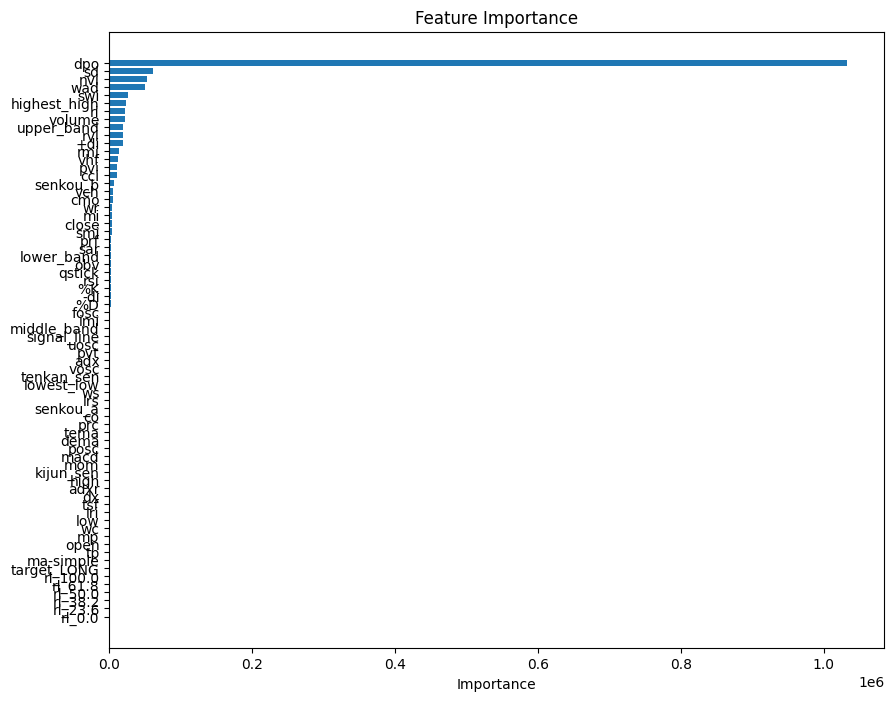

In [50]:
# feature_importances = tuned_model.feature_importance(importance_type='gain')
# feature_names = btc_data_copy_features.columns

# feature_importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# plt.figure(figsize=(10, 8))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel('Importance')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()
# plt.show()

It seems that DPO overpowers other indicators
Let's temporarily remove it and test the model

configuration: w/o dpo and scaling

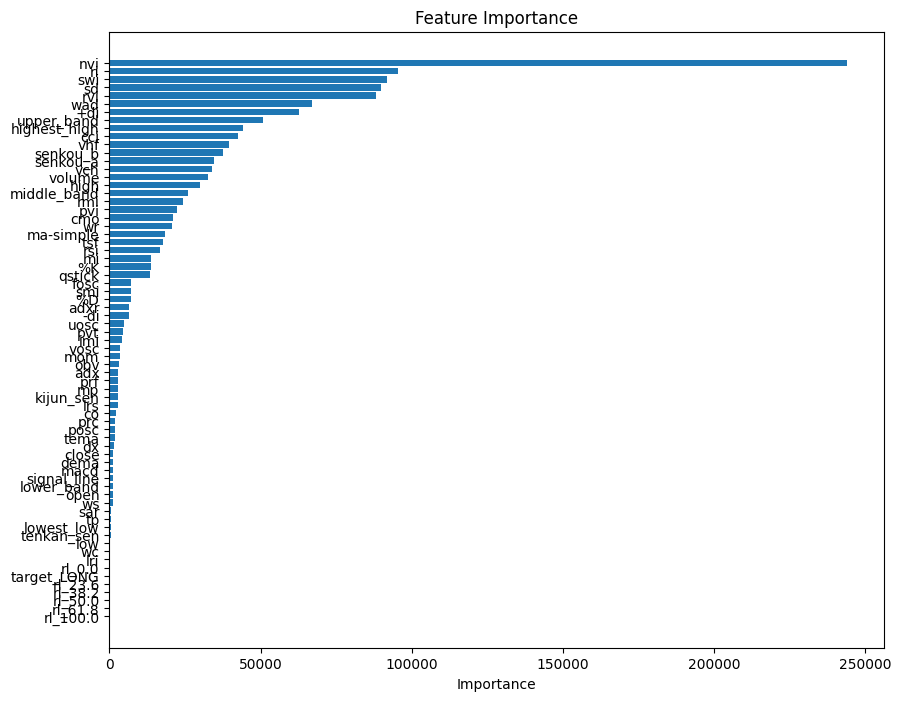

In [29]:
# feature_importances = tuned_model.feature_importance(importance_type='gain')
# feature_names = btc_data_copy_features.columns

# feature_importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# plt.figure(figsize=(10, 8))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel('Importance')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()
# plt.show()

We can assume that dpo is a substantial feature for the chosen model

Let's look at feature importance for other configurations, including scaling

configuration: with dpo and MinMaxScaler

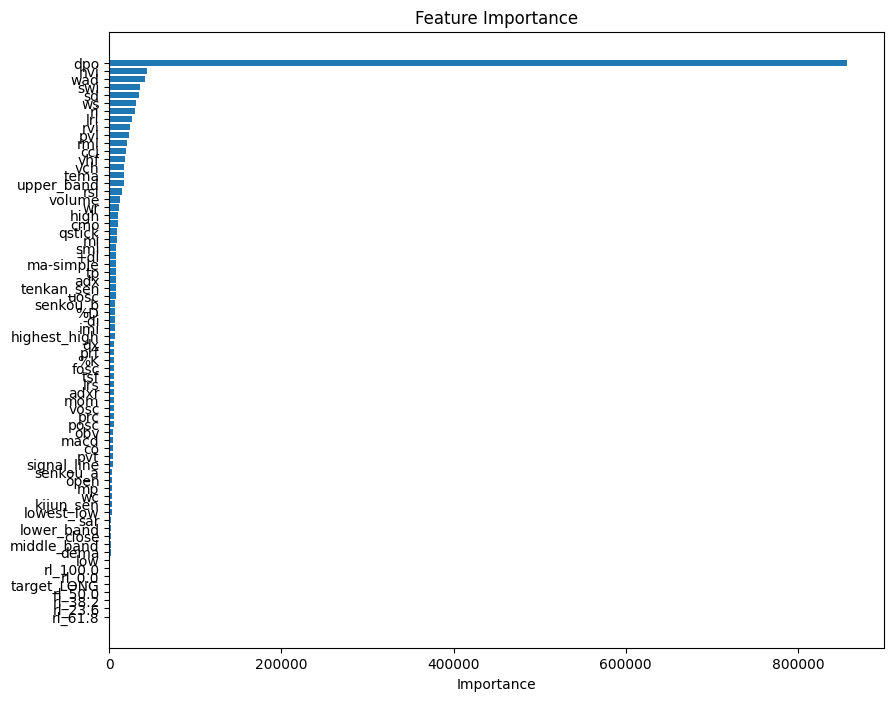

In [76]:
# feature_importances = tuned_model.feature_importance(importance_type='gain')
# feature_names = btc_data_copy_features.columns

# feature_importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# plt.figure(figsize=(10, 8))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel('Importance')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()
# plt.show()

configuration: with dpo and StandardScaler

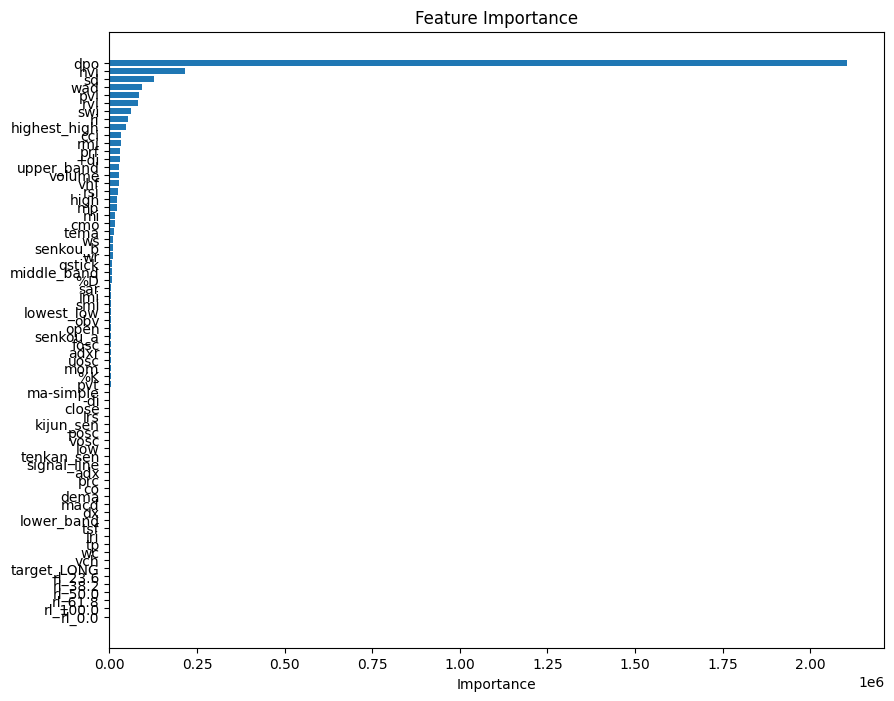

In [59]:
# feature_importances = tuned_model.feature_importance(importance_type='gain')
# feature_names = btc_data_copy_features.columns

# feature_importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# plt.figure(figsize=(10, 8))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel('Importance')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()
# plt.show()

configuration: with dpo and RobustScaler

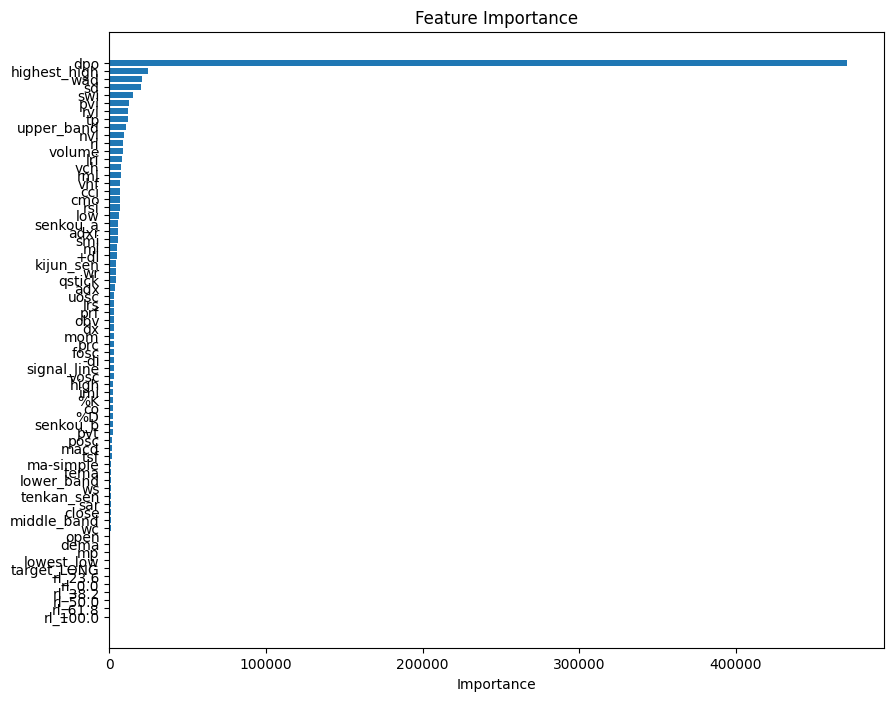

In [42]:
# feature_importances = tuned_model.feature_importance(importance_type='gain')
# feature_names = btc_data_copy_features.columns

# feature_importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# plt.figure(figsize=(10, 8))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel('Importance')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()
# plt.show()

It seems that scaling doesn't help that much. Let's try a simple feature engineering, namely moving average

configuration: moving_average_dpo with windows = 3, a small number of features, w/o dpo and scaling

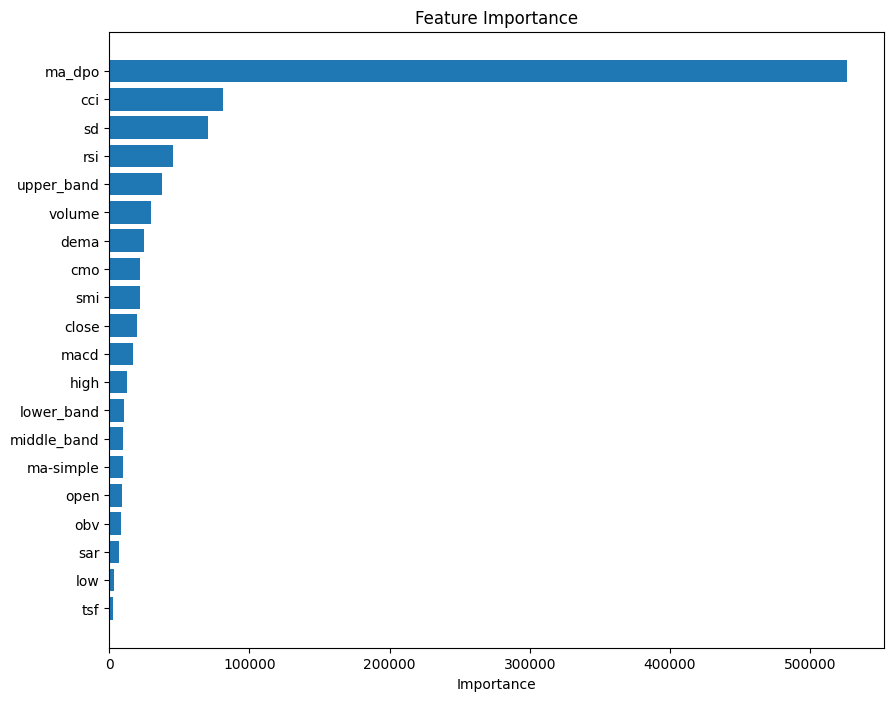

In [48]:
feature_importances = tuned_model.feature_importance(importance_type='gain')
feature_names = btc_data_copy_features.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

current configuration: moving_average_dpo with windows = 5, a small number of features and w/o scaling and dpo

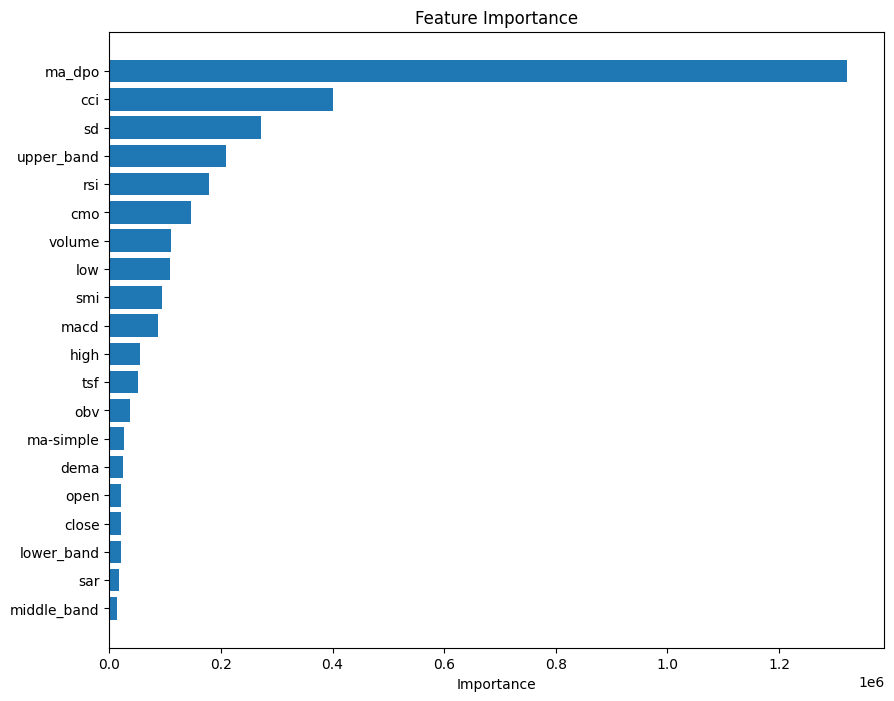

In [34]:
# feature_importances = tuned_model.feature_importance(importance_type='gain')
# feature_names = btc_data_copy_features.columns

# feature_importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# plt.figure(figsize=(10, 8))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel('Importance')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()
# plt.show()

The last configuration has shown the best model performance, so we'll use it further

---

## Bybit API

### Bybit Mainnet Demo Trading connection

In [35]:
api_key_ = api_public
api_secret_ = api_secret
session = HTTP(
    demo=True,
    api_key=api_key_,
    api_secret=api_secret_
)

### Bot initialization 

In [37]:
# logging data for further analysis
date_list = []
probability_list = []
price_list = []

In [50]:
@retry(stop=stop_after_attempt(5), wait=wait_fixed(10))
def get_wallet_balance_with_retry(session, accountType='UNIFIED', coin='BTC'):
    return session.get_wallet_balance(accountType=accountType, coin=coin)

def generate_indicators(df):
    
    ''' makes new features based on OHLCV data'''
    
    combined_df = df.copy()
    
    indicator_classes = [cls for _, cls in inspect.getmembers(ti, inspect.isclass)]
    
    for indicator_class in indicator_classes:
        try:
            indicator = indicator_class(input_data=df)
            indicator_data = indicator.getTiData()
            combined_df = combined_df.join(indicator_data, how='left')
        except Exception as e:
            pass
            
    combined_df['target_label'] = combined_df['close'].diff(-1).apply(lambda x: 1 if x <= 0 else -1)
    
    return combined_df

def get_clean_ohlcv_data(symbol="BTCUSDT", interval=5):
    
    ''' extracts OHLCV data from Bybit for the last 5 minutes'''
    
    end_time = int(datetime.now().timestamp())  # Current time in seconds
    start_time = end_time - (5 * 60)  # time 5 min ago in seconds
    try:
        response = session.get_kline(
            category="spot",
            symbol=symbol,
            interval=str(interval),
            start=start_time * 1000,  # start_time to milliseconds
            end=end_time * 1000       # end_time to milliseconds
        )

        kline = response['result']['list'][0]
        ohlcv_data = {
                    "date": datetime.fromtimestamp(int(kline[0]) / 1000),
                    "open": float(kline[1]),
                    "high": float(kline[2]),
                    "low": float(kline[3]),
                    "close": float(kline[4]),
                    "volume": float(kline[5])
                    }
        
        df = pd.DataFrame(ohlcv_data.items()).T
        df.columns = df.iloc[0]
        df = df.iloc[1:].set_index('date')
        df = df.astype({
            'open':'Float64',
            'high':'Float64',
            'low':'Float64',
            'close':'Float64',
            'volume':'Float64'
        })
        return df
    except Exception as e:
        print("Error extracting data:", e)

def input_data_preprocessing():
    
    ''' combines previous OHLCV data with the newest one and processes it'''
    
    new_ohlcv_row = get_clean_ohlcv_data()
    last_55_rows_df = btc_data_copy_v1.iloc[-300:, :5]
    ohlcv_data = pd.concat([last_55_rows_df, new_ohlcv_row], axis=0)
    featured_data = generate_indicators(ohlcv_data)
    featured_data = featured_data.drop(['adl', 'cmf', 'emv_ma', 'emv', 'mfi', 'vrc', 'target_label'], axis=1)
    nan = featured_data[featured_data.columns[featured_data.isna().sum() > 0]].columns
    featured_data[nan] = featured_data[nan].fillna(featured_data[nan].rolling(window=50, min_periods=1).mean())
    featured_data = featured_data[['open', 'high', 'low', 'close', 'volume', 'dpo', 'dema', 'ma-simple', 'macd', 'sar', 'rsi', 'smi', 'cci', 'cmo', 'middle_band', 'upper_band', 'lower_band', 'sd', 'obv', 'tsf']]
    featured_data['ma_dpo'] = featured_data['dpo'].rolling(window=5).mean()
    featured_data['ma_dpo'] = featured_data['ma_dpo'].interpolate(method='cubic')
    featured_data = featured_data.drop('dpo', axis=1)
    return featured_data.iloc[[-1]]

def get_bitcoin_signal():
    
    '''ohlcv_data processing, features generation, 
    PCA application and model prediction'''
    
    preprocessed_data = input_data_preprocessing()
    y_pred = tuned_model.predict(preprocessed_data)
    last_btc_price = preprocessed_data['close'].iloc[-1]
    last_date = preprocessed_data.index[-1]
    # FIXME продумать логику добавления новых данных в исходные датасеты (зазписать в .csv)
    return (y_pred, last_btc_price, last_date)


def place_order(order_side: str, amount): #FIXME
    
    '''makes a "buy" or "sell" order'''
    
    try:
        order = session.place_order(
                                    category="spot",
                                    symbol="BTCUSDT",
                                    side=order_side, # Buy or Sell
                                    orderType="Market",
                                    qty=str(amount), # BTC value for Sell and USDT value for Buy
                                    marketunit="quoteCoin",
                                    timeInForce="IOC",
                                    isLeverage=0,
                                    orderFilter="Order"
                                    )
        print(f"{"Buy order" if order_side=="Buy" else "Sell order"} executed:", order)
    except Exception as e:
        print("Error making an order:", e)

def trading_bot(threshold=0.7, amount=1000):
    while True:
        probability, last_btc_price, last_date = get_bitcoin_signal()
        date_list.append(last_date)
        probability_list.append(probability)
        price_list.append(last_btc_price)
        btc_balance_in_usdt = float(get_wallet_balance_with_retry(session)['result']['list'][0]['coin'][0]['usdValue'])
        btc_balance_in_btc = float(get_wallet_balance_with_retry(session)['result']['list'][0]['coin'][0]['walletBalance'][:6])
        usdt_balance = float(get_wallet_balance_with_retry(session, coin='USDT')['result']['list'][0]['coin'][0]['usdValue'])
        if probability >= threshold and btc_balance_in_usdt > 100:
            print(f'Hold your tokens! Price increase probability: {probability[0]:.3f}')
        elif probability >= threshold and btc_balance_in_usdt <= 100:
            print(f"Buy signal! Price increase probability: {probability[0]:.3f}")
            place_order("Buy", amount)
        elif probability <= threshold and btc_balance_in_usdt > 100:
            print(f"Sell signal! Price increase probability: {probability[0]:.3f}")
            place_order("Sell", btc_balance_in_btc)
        else:
            print(f"Wait for a better opportunity. Price increase probability: {probability[0]:.3f}")
        
        btc_balance_in_usdt = float(get_wallet_balance_with_retry(session)['result']['list'][0]['coin'][0]['usdValue'])
        usdt_balance = float(get_wallet_balance_with_retry(session, coin='USDT')['result']['list'][0]['coin'][0]['usdValue'])
        print(f'Current BTC price: {last_btc_price}',
              f'BTC balance in USD: {btc_balance_in_usdt}',
              f'USDT balance: {usdt_balance}', sep='\n')    
        time.sleep(300)  # Checkout every 5 min
        
# Bot launching
trading_bot()

Buy signal! Price increase probability: 0.708
Buy order executed: {'retCode': 0, 'retMsg': 'OK', 'result': {'orderId': '1821196255578295552', 'orderLinkId': '1821196255578295553'}, 'retExtInfo': {}, 'time': 1731839511760}
Current BTC price: 91104.82
BTC balance in USD: 1004.1692527
USDT balance: 124817.86953595


KeyboardInterrupt: 

Converting logging data into dataframe

In [95]:
df = pd.DataFrame({'date':date_list, 'probability':probability_list, 'price':price_list})
df